In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, classification_report
import matplotlib.cm as cm
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.covariance import OAS, LedoitWolf

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import seaborn as sns

import plotly.graph_objects as go

In [2]:
data = pd.read_csv('data.csv', encoding='ISO-8859-1')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [3]:
data.dropna(inplace=True)

In [4]:
data.describe()

Quantity      UnitPrice     CustomerID
count  406829.000000  406829.000000  406829.000000
mean       12.061303       3.460471   15287.690570
std       248.693370      69.315162    1713.600303
min    -80995.000000       0.000000   12346.000000
25%         2.000000       1.250000   13953.000000
50%         5.000000       1.950000   15152.000000
75%        12.000000       3.750000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [5]:
data = data[data['Quantity'] > 0]
data = data[data['UnitPrice'] > 0]
data.shape

(397884, 8)

In [6]:
data['sale'] = data['Quantity'] * data['UnitPrice']

In [7]:
data.describe()

Quantity      UnitPrice     CustomerID           sale
count  397884.000000  397884.000000  397884.000000  397884.000000
mean       12.988238       3.116488   15294.423453      22.397000
std       179.331775      22.097877    1713.141560     309.071041
min         1.000000       0.001000   12346.000000       0.001000
25%         2.000000       1.250000   13969.000000       4.680000
50%         6.000000       1.950000   15159.000000      11.800000
75%        12.000000       3.750000   16795.000000      19.800000
max     80995.000000    8142.750000   18287.000000  168469.600000

In [8]:
agg_trans = data.groupby(['CustomerID', 'InvoiceNo'], as_index=False).agg({'Quantity': ['sum', 'count'], 
                                                                           'sale': 'sum'},
                                                                         )
agg_trans

CustomerID InvoiceNo Quantity            sale
                                sum count       sum
0        12346.0    541431    74215     1  77183.60
1        12347.0    537626      319    31    711.79
2        12347.0    542237      315    29    475.39
3        12347.0    549222      483    24    636.25
4        12347.0    556201      196    18    382.52
...          ...       ...      ...   ...       ...
18527    18283.0    579673      134    52    223.61
18528    18283.0    580872      142    50    208.00
18529    18287.0    554065      488    29    765.28
18530    18287.0    570715      990    38   1001.32
18531    18287.0    573167      108     3     70.68

[18532 rows x 5 columns]

In [9]:
agg_trans.columns = ['CustomerID', 'InvoiceNo', 'total quantity', 'unique products', 'total sale']

In [10]:
agg_trans.head()

CustomerID InvoiceNo  total quantity  unique products  total sale
0     12346.0    541431           74215                1    77183.60
1     12347.0    537626             319               31      711.79
2     12347.0    542237             315               29      475.39
3     12347.0    549222             483               24      636.25
4     12347.0    556201             196               18      382.52

In [11]:
agg_cust = agg_trans.groupby('CustomerID', as_index=False).agg({
    'total quantity': ['sum', 'mean'],
    'unique products': 'mean',
    'total sale': ['sum', 'mean', 'count']})
agg_cust.columns = ['CustomerID', 'total articles', 'articles per tran', 'unique articles per trans', 'total sale', 'mean sale', 'total trans']
agg_cust

CustomerID  total articles  articles per tran  \
0        12346.0           74215       74215.000000   
1        12347.0            2458         351.142857   
2        12348.0            2341         585.250000   
3        12349.0             631         631.000000   
4        12350.0             197         197.000000   
...          ...             ...                ...   
4333     18280.0              45          45.000000   
4334     18281.0              54          54.000000   
4335     18282.0             103          51.500000   
4336     18283.0            1397          87.312500   
4337     18287.0            1586         528.666667   

      unique articles per trans  total sale     mean sale  total trans  
0                      1.000000    77183.60  77183.600000            1  
1                     26.000000     4310.00    615.714286            7  
2                      7.750000     1797.24    449.310000            4  
3                     73.000000     1757.55   1757.550000            1  
4                     17.000000      334.40    334.400000            1  
...                         ...         ...           ...          ...  
4333                  10.000000      180.60    180.600000            1  
4334                   7.000000       80.82     80.820000            1  
4335                   6.000000      178.05     89.025000            2  
4336                  47.250000     2094.88    130.930000           16  
4337                  23.333333     1837.28    612.426667            3  

[4338 rows x 7 columns]

In [12]:
agg_cust.describe()

CustomerID  total articles  articles per tran  \
count   4338.000000     4338.000000        4338.000000   
mean   15300.408022     1191.289073         253.478280   
std     1721.808492     5046.081546        1312.905974   
min    12346.000000        1.000000           1.000000   
25%    13813.250000      160.000000          93.000000   
50%    15299.500000      379.000000         161.750000   
75%    16778.750000      992.750000         272.000000   
max    18287.000000   196915.000000       74215.000000   

       unique articles per trans     total sale     mean sale  total trans  
count                4338.000000    4338.000000   4338.000000  4338.000000  
mean                   22.190173    2054.266460    419.166289     4.272015  
std                    20.298379    8989.230441   1796.537944     7.697998  
min                     1.000000       3.750000      3.450000     1.000000  
25%                     9.500000     307.415000    178.625000     1.000000  
50%                    17.000000     674.485000    293.900000     2.000000  
75%                    28.250000    1661.740000    430.113750     5.000000  
max                   300.647059  280206.020000  84236.250000   209.000000

In [13]:
dates = data[['CustomerID', 'InvoiceDate']].drop_duplicates()
dates.head()

CustomerID         InvoiceDate
0      17850.0 2010-12-01 08:26:00
7      17850.0 2010-12-01 08:28:00
9      13047.0 2010-12-01 08:34:00
25     13047.0 2010-12-01 08:35:00
26     12583.0 2010-12-01 08:45:00

In [14]:
ids = dates['CustomerID'].to_numpy()
indices = np.nonzero((ids[1:] - ids[:-1]))[0] + 1
indices = np.insert(indices, 0, 0)
indices = np.insert(indices, indices.shape[0], ids.shape[0])

In [15]:
freqs = np.zeros(ids.shape[0])
for i in range(indices.shape[0] - 1):
    dates_customer = dates['InvoiceDate'][indices[i]:indices[i+1]]
    if dates_customer.shape[0] == 1:
        freqs[i] = np.nan
    else:
        freqs[i] = np.max((dates_customer.iloc[1:] - dates_customer.iloc[:-1]).dt.days)

In [16]:
max_dates = dates.groupby('CustomerID', as_index=False).max()
max_dates['global max date'] = dates['InvoiceDate'].max()
agg_cust['recency'] = (max_dates['global max date'] - max_dates['InvoiceDate']).dt.days

In [17]:
agg_cust.head()

CustomerID  total articles  articles per tran  unique articles per trans  \
0     12346.0           74215       74215.000000                       1.00   
1     12347.0            2458         351.142857                      26.00   
2     12348.0            2341         585.250000                       7.75   
3     12349.0             631         631.000000                      73.00   
4     12350.0             197         197.000000                      17.00   

   total sale     mean sale  total trans  recency  
0    77183.60  77183.600000            1      325  
1     4310.00    615.714286            7        1  
2     1797.24    449.310000            4       74  
3     1757.55   1757.550000            1       18  
4      334.40    334.400000            1      309

In [18]:
agg_cust.iloc[:, 1:].describe()

total articles  articles per tran  unique articles per trans  \
count     4338.000000        4338.000000                4338.000000   
mean      1191.289073         253.478280                  22.190173   
std       5046.081546        1312.905974                  20.298379   
min          1.000000           1.000000                   1.000000   
25%        160.000000          93.000000                   9.500000   
50%        379.000000         161.750000                  17.000000   
75%        992.750000         272.000000                  28.250000   
max     196915.000000       74215.000000                 300.647059   

          total sale     mean sale  total trans      recency  
count    4338.000000   4338.000000  4338.000000  4338.000000  
mean     2054.266460    419.166289     4.272015    91.536422  
std      8989.230441   1796.537944     7.697998   100.014169  
min         3.750000      3.450000     1.000000     0.000000  
25%       307.415000    178.625000     1.000000    17.000000  
50%       674.485000    293.900000     2.000000    50.000000  
75%      1661.740000    430.113750     5.000000   141.000000  
max    280206.020000  84236.250000   209.000000   373.000000

In [19]:
agg_cust.iloc[:, 1:].corr()

total articles  articles per tran  \
total articles                   1.000000           0.383978   
articles per tran                0.383978           1.000000   
unique articles per trans        0.022811           0.038939   
total sale                       0.922907           0.310360   
mean sale                        0.406404           0.930869   
total trans                      0.558081           0.010731   
recency                         -0.123758           0.007249   

                           unique articles per trans  total sale  mean sale  \
total articles                              0.022811    0.922907   0.406404   
articles per tran                           0.038939    0.310360   0.930869   
unique articles per trans                   1.000000    0.028668   0.051984   
total sale                                  0.028668    1.000000   0.393479   
mean sale                                   0.051984    0.393479   1.000000   
total trans                                -0.019691    0.553650   0.019063   
recency                                    -0.106795   -0.122097  -0.000276   

                           total trans   recency  
total articles                0.558081 -0.123758  
articles per tran             0.010731  0.007249  
unique articles per trans    -0.019691 -0.106795  
total sale                    0.553650 -0.122097  
mean sale                     0.019063 -0.000276  
total trans                   1.000000 -0.260578  
recency                      -0.260578  1.000000

/home/diegoxfx/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/home/diegoxfx/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

/home/diegoxfx/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/home/diegoxfx/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Ma

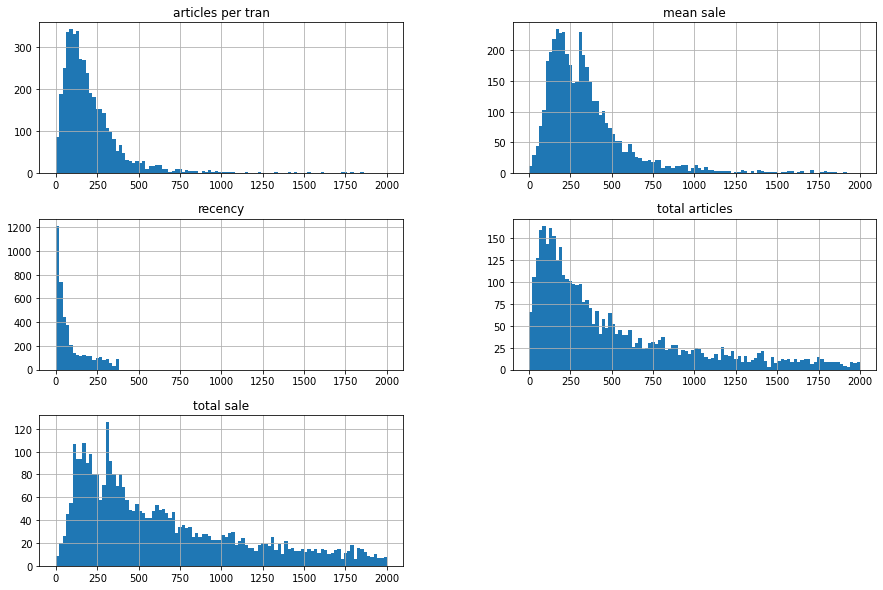

In [20]:
agg_cust.hist(column=['articles per tran', 'mean sale', 'recency', 'total articles', 'total sale'],
                                         figsize=(15, 10), bins=100, range=(0, 2000))
plt.show()

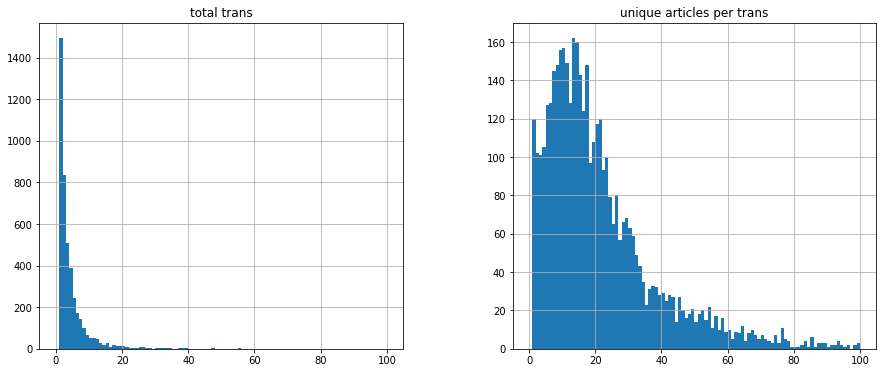

In [21]:
agg_cust.hist(column=['unique articles per trans', 'total trans'],
                                         figsize=(15, 6), bins=100, range=(0, 100))
plt.show()

In [22]:
X = agg_cust[agg_cust['total trans'] > 0][[ 'mean sale', 'total trans', 'recency']]

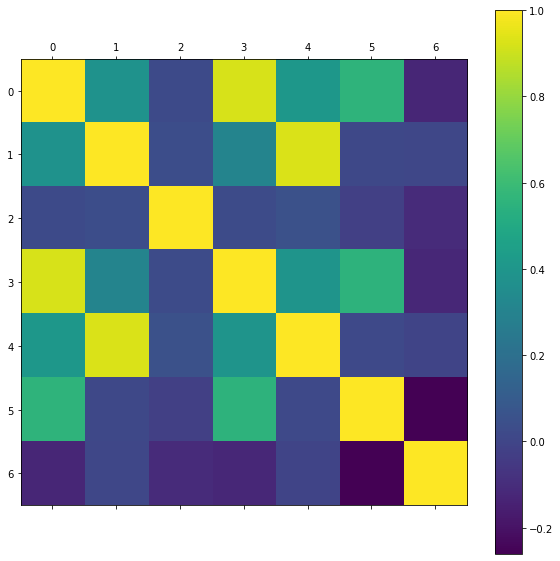

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(agg_cust.iloc[:, 1:].corr())
fig.colorbar(cax)
plt.show()

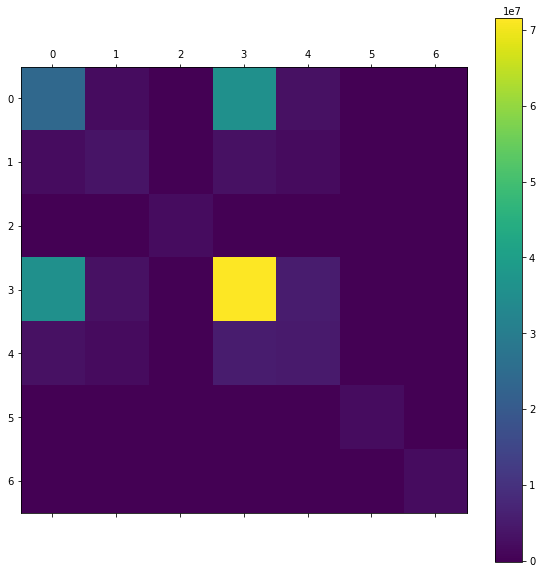

In [24]:
cov = LedoitWolf().fit(agg_cust.iloc[:, 1:]).covariance_

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(cov)
fig.colorbar(cax)
plt.show()

/home/diegoxfx/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/home/diegoxfx/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

/home/diegoxfx/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/home/diegoxfx/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Ma

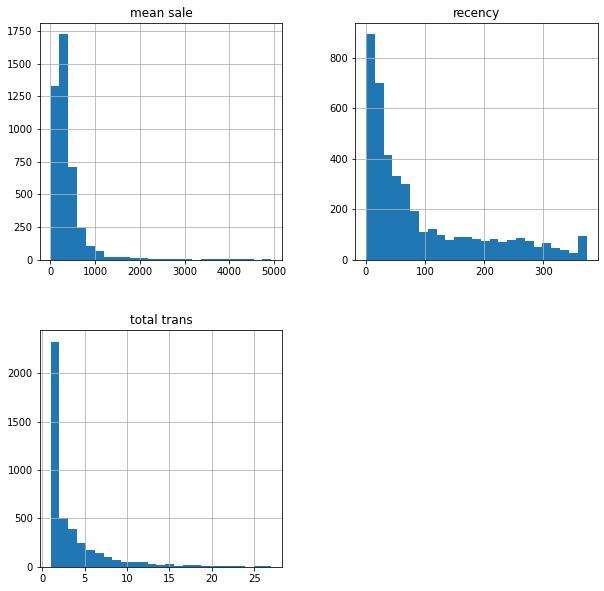

In [25]:
X = X[(np.abs(stats.zscore(X)) < 3).all(axis=1)]
X.hist(bins=25, figsize=(10, 10))
plt.show()

In [26]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

For n_clusters = 2 The average silhouette_score is : 0.3744183449047726
For n_clusters = 3 The average silhouette_score is : 0.446676379087818
For n_clusters = 4 The average silhouette_score is : 0.47563233488771645
For n_clusters = 5 The average silhouette_score is : 0.4754823111113108
For n_clusters = 6 The average silhouette_score is : 0.3945680417447505


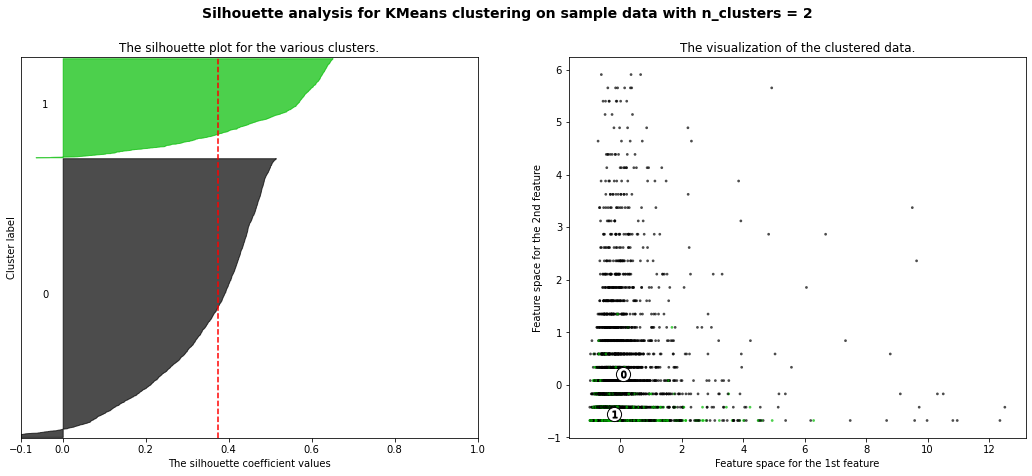

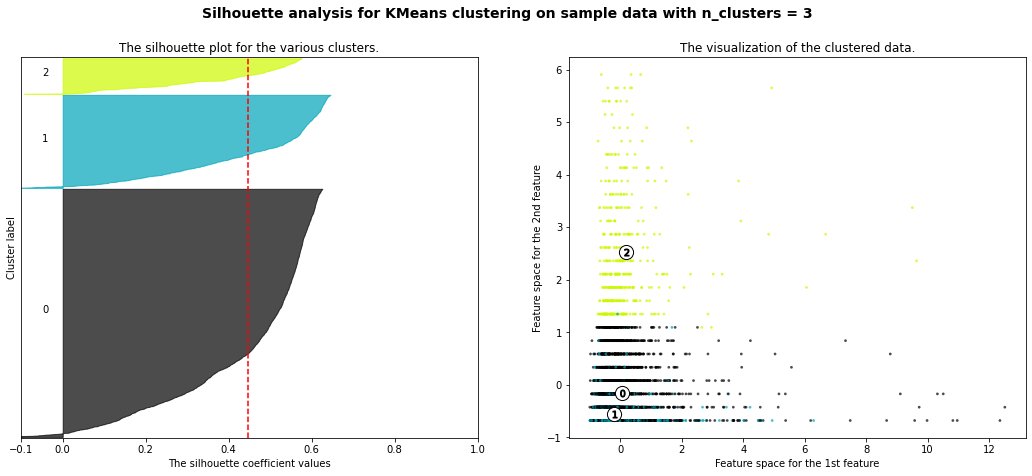

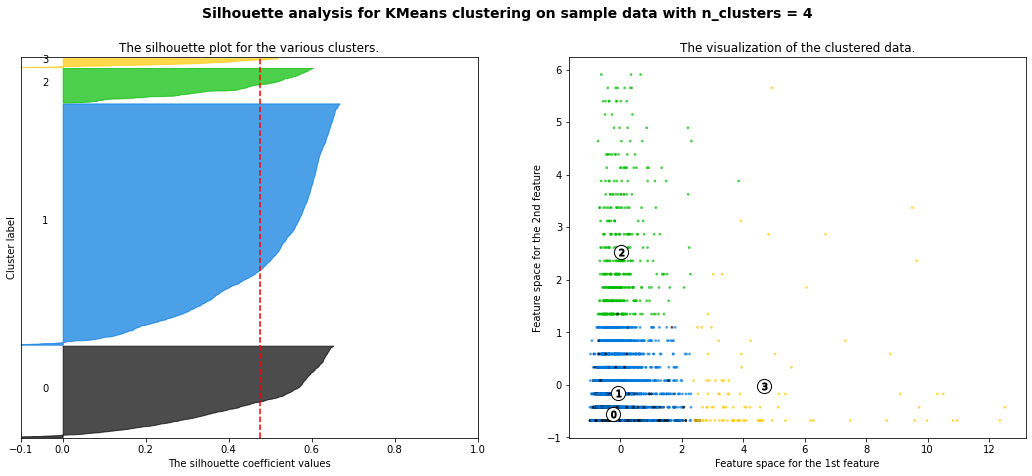

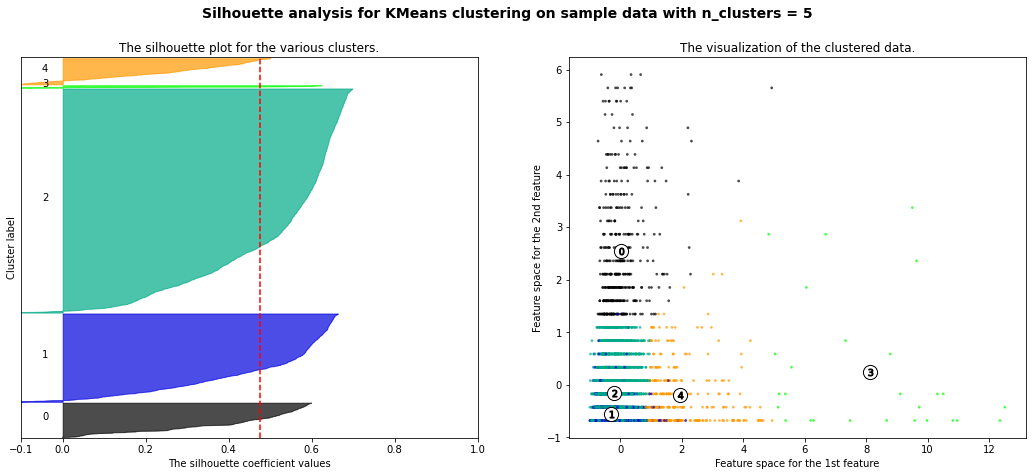

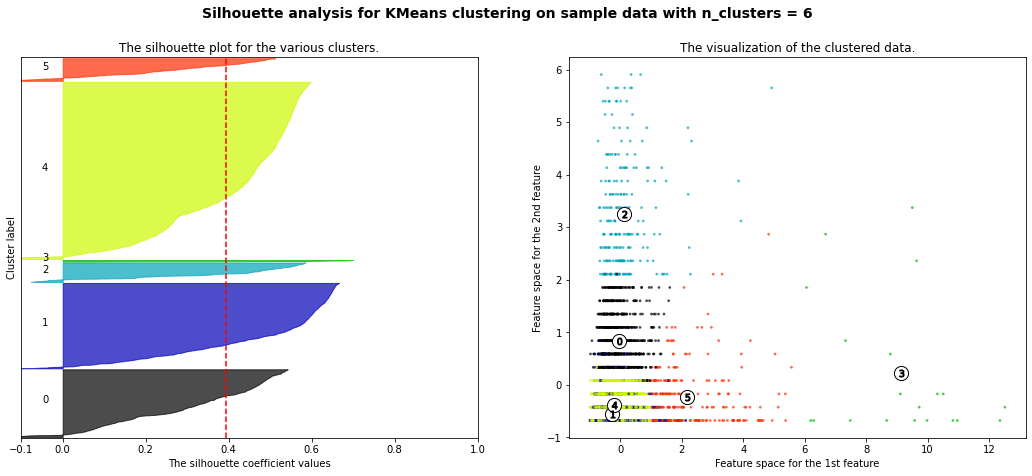

In [27]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_jobs=-1)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels, metric='mahalanobis')
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='mahalanobis')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [28]:
kmeans = KMeans(n_clusters=4).fit(X)
clusters = kmeans.predict(X)

In [29]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

In [30]:
pca.explained_variance_ratio_

array([0.47049618, 0.32592768])

In [31]:
x = agg_cust[agg_cust['total trans'] > 0][['recency', 'total trans', 'mean sale']]
x = x[(np.abs(stats.zscore(x)) < 3).all(axis=1)]
#X = X[(np.abs(stats.zscore(X)) < 3).all(axis=1)]
x = x.to_numpy()

fig = go.Figure(data=[go.Scatter(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hovertext=clusters,
    mode='markers',
    marker=dict(
        size=6,
        color=clusters,                # set color to an array/list of desired values
        opacity=0.8
    ),
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [32]:
x = agg_cust[agg_cust['total trans'] > 0][['recency', 'total trans', 'mean sale']]
x = x[(np.abs(stats.zscore(x)) < 3).all(axis=1)]
x.describe()

recency  total trans    mean sale
count  4279.000000  4279.000000  4279.000000
mean     92.474644     3.688245   367.463894
std     100.026127     3.948006   364.864267
min       0.000000     1.000000     3.450000
25%      17.000000     1.000000   178.294444
50%      51.000000     2.000000   291.992857
75%     143.000000     4.000000   425.954333
max     373.000000    27.000000  4932.130000

In [33]:
import plotly.express as px
X = agg_cust[agg_cust['total trans'] > 0][[ 'mean sale', 'total trans', 'recency']]
X = X[(np.abs(stats.zscore(X)) < 3).all(axis=1)]
X['cluster'] = clusters
fig = px.scatter_3d(X, x='recency', y='total trans', z='mean sale',
              color='cluster')
fig.show()